In [1]:
!pip install tensorflow_hub
!pip install keras tf-models-official pydot graphviz

     |████████████████████████████████| 1.1MB 17.5MB/s 
     |████████████████████████████████| 102kB 11.2MB/s 
     |████████████████████████████████| 37.6MB 80kB/s 
     |████████████████████████████████| 1.2MB 51.7MB/s 
     |████████████████████████████████| 51kB 8.9MB/s 
     |████████████████████████████████| 706kB 44.9MB/s 
     |████████████████████████████████| 174kB 57.7MB/s 
     |████████████████████████████████| 358kB 53.6MB/s 
  Created wheel for py-cpuinfo: filename=py_cpuinfo-8.0.0-cp37-none-any.whl size=22245 sha256=1b924ea594ec575c6b9df7ff825a3bff3030565a9fb5e27ddfa5633c2a1312f5
  Stored in directory: /root/.cache/pip/wheels/2e/15/f5/aa2a056d223903b52cf4870134e3a01df0c723816835dd08db
  Created wheel for seqeval: filename=seqeval-1.2.2-cp37-none-any.whl size=16172 sha256=670a2f7a2f32c07220c5f26db9795b989e4ddd4297b4527407f7f2e4f6b942cf
  Stored in directory: /root/.cache/pip/wheels/52/df/1b/45d75646c37428f7e626214704a0e35bd3cfc32eda37e59e5f
Successfully built py-cpuinfo

In [2]:
import os

import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub

from keras.utils import np_utils

import official.nlp.bert.bert_models
import official.nlp.bert.configs
import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization as tokenization

from official.modeling import tf_utils
from official import nlp
from official.nlp import bert

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

1 Physical GPUs, 1 Logical GPUs
Version:  2.4.1
Eager mode:  True
Hub version:  0.11.0
GPU is available


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df = pd.read_csv('/content/drive/My Drive/BT4222/data/labeled_twitter.csv',
                 encoding='ISO-8859-1', 
                 names=[
                        'target',
                        'id',
                        'date',
                        'flag',
                        'user',
                        'text'
                        ])

In [5]:
df.head()

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


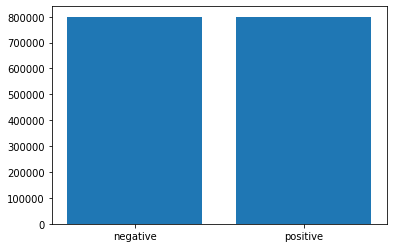

In [6]:
classes = df.target.unique()
counts = []

for i in classes:
  count = len(df[df.target==i])
  counts.append(count)

plt.bar(['negative', 'positive'], counts)
plt.show()

In [7]:
df['upper'] = [np.sum([i.isupper() for i in l])/len(l) for l in df.text]

In [8]:
for i in df.target.unique():
  print('Target: ', i, 'Score: ', df[df.target == i]['upper'].mean())

Target:  0 Score:  0.04320155098988484
Target:  4 Score:  0.04989933275850178


In [9]:
df[['target', 'upper']].corr()

,target,upper
target,1.000000,0.046258
upper,0.046258,1.000000


In [10]:
df['wkd'] = [i[0:3] for i in df['date']]

In [11]:
negativeCount = df[df.target == 0]['wkd'].value_counts()
positiveCount = df[df.target == 4]['wkd'].value_counts()

In [12]:
countDf = pd.DataFrame()
countDf['wkd'] = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
countDf['negative'] = [negativeCount[i] for i in countDf['wkd']]
countDf['positive'] = [positiveCount[i] for i in countDf['wkd']]

countDf

,wkd,negative,positive
0,Mon,132539,177666
1,Tue,101051,84799
2,Wed,68473,28333
3,Thu,80132,25903
4,Fri,114600,110994
5,Sat,157734,173221
6,Sun,145471,199084


In [13]:
for i in df.wkd.unique():
  df[i] = [int(i==l) for l in df.wkd]

In [14]:
df[['target','Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']].corr()['target']

target    1.000000
Mon       0.071343
Tue      -0.031701
Wed      -0.105225
Thu      -0.136250
Fri      -0.006476
Sat       0.023897
Sun       0.081516
Name: target, dtype: float64

In [15]:
df['hour'] = [i[11:13] for i in df['date']]

In [16]:
hourCount = pd.DataFrame()

hourCount['hour'] = df['hour'].unique()
countDict = {}

for i in df.target.unique():
  countDict[i] = df[df.target == i]['hour'].value_counts()

In [17]:
for i in countDict:
  if i == 0:
    sentiment = 'negative'
  else:
    sentiment = 'positive'
  hourCount[sentiment] = [countDict[i][h] for h in hourCount['hour']]

hourCount.sort_values(by=['hour'], inplace=True)
hourCount.reset_index(drop=True, inplace=True)
hourCount

,hour,negative,positive
0,00,35582,45283
1,01,30581,44687
2,02,30171,43820
3,03,31717,42536
4,04,34946,42049
5,05,37774,40849
6,06,40076,40776
7,07,42208,41446
8,08,40166,36121
9,09,36511,30767


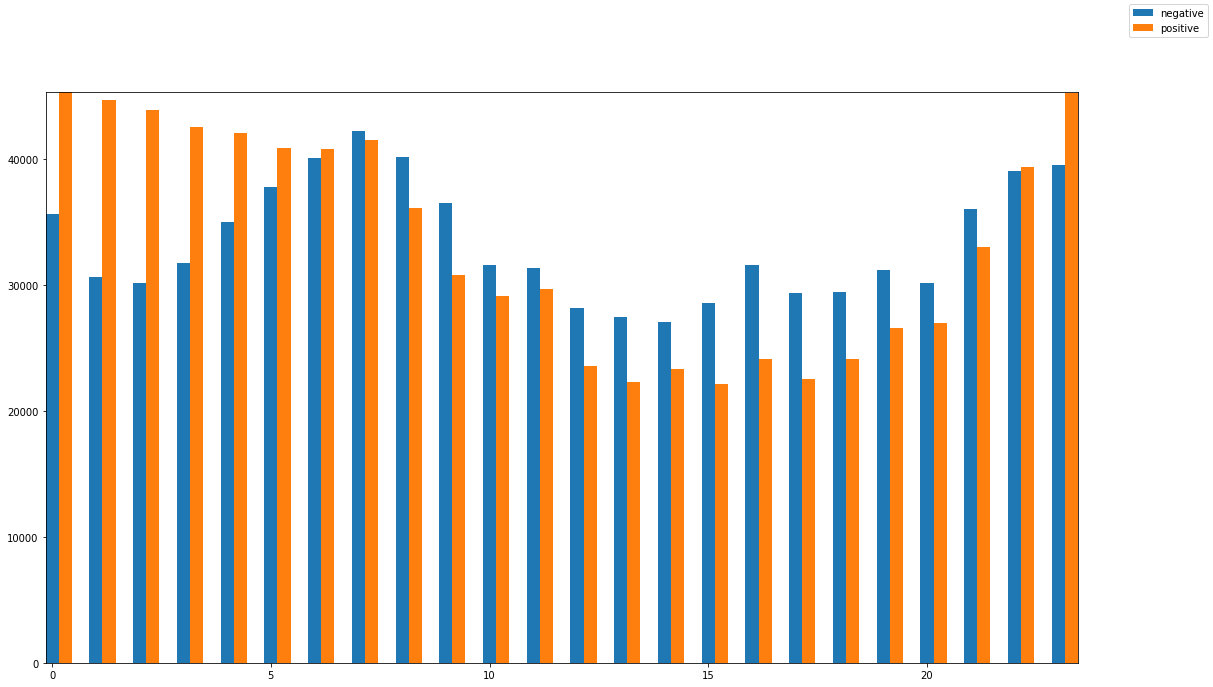

In [18]:
w = 0.3
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
for count, i in enumerate(hourCount.columns[1:]):
  ax.bar(x=hourCount.index+count*w, width=w, height=hourCount[i])

ax.autoscale(tight=True)
fig.set_size_inches(18.5, 10.5)
fig.legend(hourCount.columns[1:])
fig.show()

In [19]:
for i in df.hour.unique():
  df[i] = [int(i==l) for l in df.hour]

In [20]:
cols = [i for i in hourCount.hour]
cols.append('target')

df[cols].corr()['target']

00        0.027678
01        0.041639
02        0.040619
03        0.032143
04        0.020742
05        0.008891
06        0.001997
07       -0.002140
08       -0.011864
09       -0.017887
10       -0.008196
11       -0.005427
12       -0.016220
13       -0.018768
14       -0.013507
15       -0.022916
16       -0.025459
17       -0.023964
18       -0.018633
19       -0.015632
20       -0.010599
21       -0.009386
22        0.000846
23        0.016012
target    1.000000
Name: target, dtype: float64

# Modeling

### Train/Test split

In [21]:
sample_size = int(len(df)*0.08)
sampleDf = df.sample(sample_size, random_state=23)
wkd = sampleDf.wkd.values
x = sampleDf.text.values
y = sampleDf.target.values
wkd_train, wkd_test, x_train, x_test, y_train, y_test = train_test_split(wkd, x, y, test_size=0.20, random_state=32)

### Label Encoding

In [22]:
encoder = LabelEncoder()
encoder.fit(y)
encoded_Y_test = encoder.transform(y_test)
encoded_Y_train = encoder.transform(y_train)

# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_test = np_utils.to_categorical(encoded_Y_test)
dummy_y_train = np_utils.to_categorical(encoded_Y_train)

In [23]:
encoder_fname = 'twitter_classes_2.npy'
my_wd = '/content/drive/My Drive/BT4222/data/'
np.save(os.path.join(my_wd, encoder_fname) , encoder.classes_)

### Tokenization

In [24]:
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/2",
                            trainable=True)

In [25]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [26]:
do_lower_case

False

In [27]:
tokenizer.convert_tokens_to_ids(['[CLS]', '[SEP]'])

[101, 102]

### Prep inputs

In [28]:
def encode_names(n, tokenizer):
   tokens = list(tokenizer.tokenize(n))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

tweets = tf.ragged.constant([encode_names(n, tokenizer) for n in x_train])
cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*tweets.shape[0]
input_word_ids = tf.concat([cls, tweets], axis=-1)

lens = [len(i) for i in input_word_ids]

In [29]:
max_seq_length = max(lens)
print('Max length is:', max_seq_length)

max_seq_length = int(1.5*max_seq_length)
print('Max length is:', max_seq_length)

Max length is: 160
Max length is: 240


In [30]:
featureEncoder = LabelEncoder()
featureEncoder.fit(wkd)

# encode
encoded_wkd_train = featureEncoder.transform(wkd_train)
encoded_wkd_test = featureEncoder.transform(wkd_test)

# convert integers to dummy variables (i.e. one hot encoded)
dummy_wkd_train = np_utils.to_categorical(encoded_wkd_train)
dummy_wkd_test = np_utils.to_categorical(encoded_wkd_test)

In [31]:
# save for next time if you want to use this encoder
featureEncoder_fname = 'twitter_wkd_2.npy'
my_wd = '/content/drive/My Drive/BT4222/data/'
np.save(os.path.join(my_wd, featureEncoder_fname) , featureEncoder.classes_)

In [32]:
def encode_names(n, tokenizer):
   tokens = list(tokenizer.tokenize(n))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

def bert_encode(string_list,
                tokenizer, 
                new_feature,  # [NEW]
                new_feature_class_count,  # [NEW] 
                max_seq_length):  
  num_examples = len(string_list)
  
  string_tokens = tf.ragged.constant([
      encode_names(n, tokenizer) for n in np.array(string_list)])

  cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*string_tokens.shape[0]
  input_word_ids = tf.concat([cls, string_tokens], axis=-1)

  input_mask = tf.ones_like(input_word_ids).to_tensor(shape=(None, max_seq_length))

  type_cls = tf.zeros_like(cls)
  type_tokens = tf.ones_like(string_tokens)
  input_type_ids = tf.concat(
      [type_cls, type_tokens], axis=-1).to_tensor(shape=(None, max_seq_length))
  feature = tf.ragged.constant(new_feature).to_tensor(shape=(None, new_feature_class_count))  # [NEW]

  inputs = {
      'input_word_ids': input_word_ids.to_tensor(shape=(None, max_seq_length)),
      'input_mask': input_mask,
      'input_type_ids': input_type_ids,
      'additional_feature': feature}  # [NEW]

  return inputs

In [33]:
feature_class_count = len(df.wkd.unique())
X_train = bert_encode(x_train, tokenizer, dummy_wkd_train, feature_class_count, max_seq_length)
X_test = bert_encode(x_test, tokenizer, dummy_wkd_test, feature_class_count, max_seq_length)

### Initial training

In [34]:
num_class = len(encoder.classes_)  # Based on available class selection
max_seq_length = max_seq_length  # we calculated this a couple cells ago

input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                       name="input_word_ids")
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                   name="input_mask")
segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                    name="segment_ids")
feature_input = tf.keras.layers.Input(shape=(feature_class_count,),  # [NEW]
                                      dtype=tf.float32, 
                                      name="additional_feature")

pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])    

output = tf.keras.layers.concatenate([pooled_output, feature_input], name='pooled_with_additional')  # [NEW]

output = tf.keras.layers.Dropout(rate=0.1)(output)  # [NEW]

  # additional dense layer here

output = tf.keras.layers.Dense(num_class, activation='softmax', name='output')(output)

model = tf.keras.Model(
    inputs={
        'input_word_ids': input_word_ids,
        'input_mask': input_mask,
        'input_type_ids': segment_ids,
        'additional_feature': feature_input  # [NEW]
        },
        outputs=output)

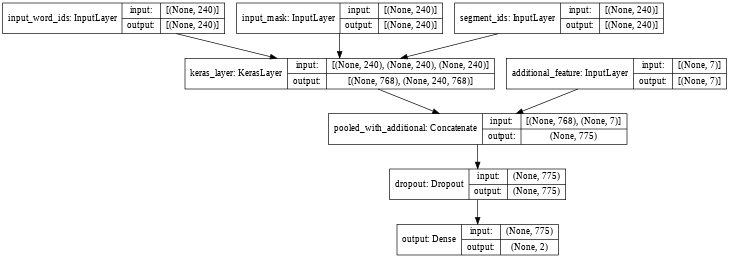

In [35]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=48)

In [36]:
epochs = 3
batch_size = 6  # select based on your GPU resources
eval_batch_size = batch_size

train_data_size = len(dummy_y_train)
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(epochs * train_data_size * 0.1 / batch_size)

optimizer = nlp.optimization.create_optimizer(
    2e-5, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps)

In [37]:
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [38]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 240)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 240)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 240)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 177853441   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

In [39]:
history = model.fit(X_train,
                    dummy_y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_test, dummy_y_test),
                    verbose=1)

In [40]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [41]:
plot_history(history)

NameError: ignored

### Model saving later use

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model_fname = 'twitter_BERT_wWKD_2'  # [NEW]
my_wd = '/content/drive/My Drive/BT4222/data/'

model.save(os.path.join(my_wd, model_fname))

### Validate saved model

In [43]:
model_fname = 'twitter_BERT_wWKD_2'
new_model = tf.keras.models.load_model(os.path.join(my_wd, model_fname))

In [44]:
loss, accuracy = new_model.evaluate(X_test, dummy_y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Testing Accuracy:  0.8289


In [45]:
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 240)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 240)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 240)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 177853441   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

In [46]:
tokenizerSaved = bert.tokenization.FullTokenizer(
    vocab_file=os.path.join(my_wd, model_fname, 'assets/vocab.txt'),
    do_lower_case=False)

If this loads, then should be fine

In [47]:
tokenizedTweet = tokenizerSaved.tokenize(x_train[0])
for i in tokenizedTweet:
  print(i, tokenizerSaved.convert_tokens_to_ids([i]))

@ [137]
phi [36500]
##lbe [74563]
##e [10112]
